In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

In [2]:
%cd /content/gdrive/MyDrive/СL_CuP

/content/gdrive/MyDrive/СL_CuP


In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
    
with open('ranking_train.jsonl', 'r') as f:
    train_data = list(f)

with open('ranking_test.jsonl', 'r') as f:
    test_data = list(f)
    
def parse_json_line(json_line):
    json_data = json.loads(json_line)
    text = json_data['text']
    comments = json_data['comments']
    comments_text = [comment['text'] for comment in comments]
    comments_score = [comment['score'] for comment in comments]
    return pd.DataFrame({'text': [text]*5, 'comment': comments_text, 'score': comments_score})

train_df = pd.concat([parse_json_line(line) for line in train_data], ignore_index=True)
test_df = pd.concat([parse_json_line(line) for line in test_data], ignore_index=True)
# Размер обучающей и тестовой выборок
print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

# Общая информация по датафреймам
print(train_df.info())
print(test_df.info())

# Статистические характеристики данных
print(train_df.describe())

Train samples: 440535
Test samples: 70020
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440535 entries, 0 to 440534
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     440535 non-null  object
 1   comment  440535 non-null  object
 2   score    440535 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 10.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70020 entries, 0 to 70019
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     70020 non-null  object
 1   comment  70020 non-null  object
 2   score    0 non-null      object
dtypes: object(3)
memory usage: 1.6+ MB
None
               score
count  440535.000000
mean        2.000000
std         1.414215
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000


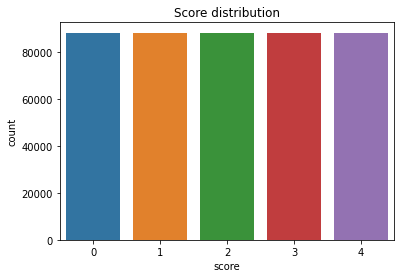

In [4]:
# Гистограмма распределения оценок комментариев
sns.countplot(x='score', data=train_df)
plt.title('Score distribution')
plt.show()

In [2]:
import os
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  !java -version

In [3]:
%%capture installation.log
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8
install_java()
!pip install spacy
!pip install language_tool_python
!python -m spacy download en_core_web_sm
!pip install transformers
!pip install tqdm
!pip install psutil
!pip install Cython

In [5]:
!pip install tensorflow-hub


     ------------------------------------ 100.6/100.6 kB 444.9 kB/s eta 0:00:00


In [53]:
import psutil
print(psutil.cpu_count(logical=True))

# Возвращает объект, содержащий информацию о памяти
memory = psutil.virtual_memory()

# Выводит доступную память в байтах
print(memory.available)

8
4231888896


In [54]:
import gc

# освобождает неиспользуемые объекты из памяти
# del some_object
gc.collect()


25531

In [55]:
memory = psutil.virtual_memory()

# Выводит доступную память в байтах
print(memory.available)

4230553600


In [46]:
!pip install memory_profiler
from memory_profiler import profile

In [47]:
from numba import jit

In [4]:
%%capture analyze_comments.log
import re
import csv
import torch
import string
import numpy as np
import spacy
import tensorflow as tf
import tensorflow_hub as hub
import nltk
import multiprocessing as mp
import language_tool_python
import concurrent.futures as futures
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial
from tqdm import tqdm
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoModelForSequenceClassification, AutoModel, AutoTokenizer, TextClassificationPipeline
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import rankdata


# Load pre-trained models
nlp = spacy.load('en_core_web_sm')
use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
sia = SentimentIntensityAnalyzer()
tool = language_tool_python.LanguageTool('en-US')

# Initialize tokenizer and pipeline
model_path = "martin-ha/toxic-comment-model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer)
tokenizer_d = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model_d = AutoModel.from_pretrained('distilbert-base-multilingual-cased')



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [59]:
# def evaluate_toxicity(comment, max_length=512, stride=256):

#     # Split comment into smaller segments
#     segments = []
#     if len(comment) > max_length:
#         # Split comment into overlapping segments
#         for i in range(0, len(comment), stride):
#             segment = comment[i:i+max_length]
#             # Force segment to be exactly 512 characters
#             segment = segment[:512]
#             segments.append(segment)
#     else:
#         segments.append(comment)

#     # Calculate toxicity score for each segment
#     toxicity_scores = []
#     for segment in segments:
#         input_ids = tokenizer.encode(segment, truncation=True, padding=True, return_tensors='pt')
#         tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
#         text = tokenizer.convert_tokens_to_string(tokens)
#         output = pipeline(text)
#         toxicity_scores.append(output[0]['score'])
    
#     # Average toxicity scores across segments
#     toxicity_score = np.mean(toxicity_scores)

#     return toxicity_score

# def compute_use_vectors(text, model, tokenizer, max_length=512, stride=256):
#     # Split input sequence into smaller segments
#     segments = []
#     if len(text) > max_length:
#         # Split text into overlapping segments
#         for i in range(0, len(text), stride):
#             segment = text[i:i+max_length]
#             # Force segment to be exactly 512 characters
#             segment = segment[:512]
#             segments.append(segment)
#     else:
#         segments.append(text)

#     # Compute embeddings for each segment
#     batch_size = 8
#     embeddings = []
#     for i in range(0, len(segments), batch_size):
#         batch_segments = segments[i:i+batch_size]
#         batch_input = tokenizer.batch_encode_plus(batch_segments, padding = True, truncation=True, return_tensors='pt')
#         batch_embeddings = model(batch_input['input_ids'], batch_input['attention_mask'])
#         last_hidden_state_tensor = batch_embeddings.last_hidden_state
#         embeddings.append(last_hidden_state_tensor.detach().cpu().numpy())


#     # Concatenate embeddings to obtain full vector representation, even if embeddings is empty
#     if len(embeddings) > 0:
#         embeddings = np.concatenate(embeddings, axis=0)
#     else:
#         embeddings = np.array([])

#     return torch.tensor(np.stack(embeddings))

@profile
@jit(nopython=True)
def analyze_comment(comment, post_text, score, sia):
    # Find number of words
    words = comment.split()
    num_words = len(words)
    
    # Find number of unique words
    unique_words = set(words)
    num_unique_words = len(unique_words)
    
    # Find number of letters and punctuation marks
    num_letters = sum([len(word) for word in words])
    num_punctuation = sum([1 for char in comment if char in string.punctuation])
    
    # Find number of uppercase letters and words
    num_uppercase_letters = sum([1 for char in comment if char.isupper()])
    num_uppercase_words = sum([1 for word in words if word.isupper()])
    
    # Find number of stop words
    # num_stop_words = len([word for word in nlp(comment) if word.is_stop])
    num_stop_words = sum([word.is_stop for word in nlp(comment)])
    
    # Find average word length
    if num_words > 0:
        avg_word_length = num_letters / num_words
    else:
        avg_word_length = 0
    
    # Find number of sentences
    # sentences = list(nlp(comment).sents)
    # num_sentences = len(sentences)
    num_sentences = sum(1 for _ in nlp(comment).sents)
    
    # Calculate sentiment score
    sentiment_score = sia.polarity_scores(comment)['compound']
    
    # Compute embeddings for post and comment
#     post_embedding = compute_use_vectors(post_text, model = model_d, tokenizer = tokenizer_d)[0]
#     comment_embedding = compute_use_vectors(comment, model = model_d, tokenizer = tokenizer_d)[0]
    
    # # pad the shorter vector with zeros
    # if comment_embedding.shape[1] > post_embedding.shape[1]:
    #     pad_width = ((0, 0), (0, comment_embedding.shape[1]-post_embedding.shape[1]))
    #     post_embedding = np.pad(post_embedding, pad_width, mode='constant')
    # else:
    #     pad_width = ((0, 0), (0, post_embedding.shape[1]-comment_embedding.shape[1]))
    #     comment_embedding = np.pad(comment_embedding, pad_width, mode='constant')

    # # compute cosine similarity
    # similarity_score = cosine_similarity(comment_embedding, post_embedding)[0][0]

    # Calculate toxicity score
    # print(type(comment))
    toxicity_score = evaluate_toxicity(comment, max_length=512, stride=256)
    
    return (post_text,
            comment,
            score,
            num_words,
            num_unique_words,
            avg_word_length,
            num_punctuation,
            num_uppercase_letters,
            num_uppercase_words,
            num_stop_words,
            num_sentences,
            len(re.findall(r'\d+', comment)), 
            len(re.findall(r'http\S+', comment)), 
            len(re.findall(r'#\w+', comment)), 
            len(re.findall(r'[^\w\s,]', comment)), 
            len(re.findall(r'\b[A-Z]{2,}\b', comment)), 
            len(tool.check(comment)),
            comment.lower().count('Edit'), 
            sum([1 for word in comment.split() if not word.isascii()]), 
            num_punctuation / len(comment), 
            len([ent for ent in nlp(comment).ents if ent.label_ in ['PERSON', 'ORG', 'GPE']]), 
            sentiment_score, 
            # similarity_score, 
            toxicity_score)


# def print_feature_statistics(result):
#     feature_names = list(result.keys())
#     feature_frequencies = [len(result[name]) for name in feature_names]
#     feature_ranks = rankdata(feature_frequencies, method='dense')
#     feature_rank_dict = {name: rank for name, rank in zip(feature_names, feature_ranks)}

#     # Sort features by their ranks
#     sorted_features = sorted(feature_rank_dict.items(), key=lambda x: x[1])

#     # Print results
#     for feature, rank in sorted_features:
#         values = result[feature]
#         if isinstance(values[0], np.ndarray):
#             values = [list(v) for v in values]
#         print(f"{feature} (rank {rank}):")
#         print(f"\tMin: {np.min(values)}")
#         print(f"\tMax: {np.max(values)}")
#         print(f"\tMean: {np.mean(values)}")
#         print(f"\tMedian: {np.median(values)}")
#         print(f"\tStd: {np.std(values)}")
#         print("")
        
# def convert_to_csv(result, filename):
#     feature_names = list(result.keys())
#     feature_frequencies = [len(result[name]) for name in feature_names]
#     feature_ranks = rankdata(feature_frequencies, method='dense')
#     feature_rank_dict = {name: rank for name, rank in zip(feature_names, feature_ranks)}

#     # Sort features by their ranks
#     sorted_features = sorted(feature_rank_dict.items(), key=lambda x: x[1])

#     with open(filename, 'w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(['Feature', 'Rank', 'Min', 'Max', 'Mean', 'Median', 'Std'])
#         for feature, rank in sorted_features:
#             values = result[feature]
#             if isinstance(values[0], np.ndarray):
#                 values = [list(v) for v in values]
#             writer.writerow([feature, rank, np.min(values), np.max(values), np.mean(values), np.median(values), np.std(values)])

In [60]:
@profile
def analyze_comments(df, sia):

    # Create a partial function to compute USE vectors
    # compute_use_vectors_partial = partial(compute_use_vectors, use=use)

#     with ProcessPoolExecutor() as executor:
#         # Analyze comments in parallel
#         futures = [executor.submit(analyze_comment, row.comment, row.text, row.score) for row in df.itertuples()]

#         # Wait for jobs to complete and process results
#         for future in tqdm(as_completed(futures), total=len(futures)):
#             results.append(future.result())

#         print("Analysis completed successfully.")

# Create a preallocated NumPy array to store results
    results = np.empty((len(df), 22), dtype=object)
    
    # Analyze comments in parallel
    with futures.ProcessPoolExecutor(max_workers=8) as executor:
        futures_list = []
        for i, row in tqdm(enumerate(df.itertuples()), total=len(df)):
            comment = row.comment
            post_text = row.text
            score = row.score

            # Submit job to executor
            future = executor.submit(analyze_comment, comment, post_text, score, sia)

            futures_list.append(future)

        # Wait for all jobs to complete
        results_list = []
        for future in tqdm(futures.wait(futures_list)[0], total=len(futures_list)):
            results_list.append(future.result())
        results = np.vstack(results_list)

    print("Analysis completed successfully.") 

#     # Analyze comments in parallel
#     with futures.ThreadPoolExecutor(max_workers=6) as executor:
#         for i, row in tqdm(enumerate(df.itertuples()), total=len(df)):
#             comment = row.comment
#             post_text = row.text
#             score = row.score

#             # Submit job to executor
#             future = executor.submit(analyze_comment, comment, post_text, score)

#             # Store result in preallocated NumPy array
#             results[i, :] = future.result()
#         print("Analysis completed successfully.")
    # Analyze comments in parallel
    # for row in tqdm(df.itertuples()):
    #     comment = row.comment
    #     post_text = row.text
    #     score = row.score

    #     # Submit job to pool
    #     job = pool.apply_async(analyze_comment, (comment, post_text, score), callback=results.append)
    #     print("Analysis completed successfully.")
    # # Close pool and wait for all jobs to complete
    # pool.close()
    # pool.join()

    # Convert results to a pandas DataFrame
    result_df = pd.DataFrame(results, columns=['text', 'comment', 'score', 
                                                'num_words', 'num_unique_words', 'avg_word_length',
                                                'num_punctuation', 'num_uppercase_letters', 'num_uppercase_words',
                                                'num_stop_words', 'num_sentences', 'numbers',
                                                'links', 'hashtags', 'emojis', 'capslock', 'errors', 'Edit', 
                                                'non_english_words', 'punctuation_freq', 'mentions','toxicity'])

    return result_df

In [ ]:
train_df_analyzed = analyze_comments(train_df, sia)
train_df_analyzed

ERROR: Could not find file C:\Users\user\AppData\Local\Temp\ipykernel_23140\165674498.py


  0%|                                                                           | 355/440535 [00:00<05:52, 1250.15it/s]


In [ ]:
tf.identity